<a href="https://colab.research.google.com/github/kranti-experiments/EVA4/blob/master/S5/MNIST_Exp1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install torchsummary

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchsummary import summary

In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1) #input -28 Output- 26 RF 3
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(64, 32, 3, padding=1)
        self.conv4 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv5 = nn.Conv2d(64, 32, 3)
        self.conv6 = nn.Conv2d(32, 10, 5)
        #self.conv7 = nn.Conv2d(32, 10, 3)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv2(F.relu(self.conv1(x)))))
        x = self.pool2(F.relu(self.conv4(F.relu(self.conv3(x)))))
        x = F.relu(self.conv6(F.relu(self.conv5(x))))
        #x = F.relu(self.conv7(x))
        x = x.view(-1, 10)
        return F.log_softmax(x)

In [3]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
            Conv2d-2           [-1, 64, 28, 28]          18,496
         MaxPool2d-3           [-1, 64, 14, 14]               0
            Conv2d-4           [-1, 32, 14, 14]          18,464
            Conv2d-5           [-1, 64, 14, 14]          18,496
         MaxPool2d-6             [-1, 64, 7, 7]               0
            Conv2d-7             [-1, 32, 5, 5]          18,464
            Conv2d-8             [-1, 10, 1, 1]           8,010
Total params: 82,250
Trainable params: 82,250
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.84
Params size (MB): 0.31
Estimated Total Size (MB): 1.16
----------------------------------------------------------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [0]:


torch.manual_seed(1)
batch_size = 128

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)


In [0]:
from tqdm import tqdm
train_losses = []
test_losses = []
train_accuracy = []
test_accuracy = []
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    train_loss = 0
    correct = 0
    processed = 0
    pbar = tqdm(train_loader)
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        train_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)
        train_losses.append(loss)
        pbar.set_description(desc= f'loss={loss.item()} batch_id={batch_idx} Accuracy = {100*correct/processed:0.2f}')

    train_loss /= len(train_loader.dataset)
    train_accuracy.append(100*correct/len(train_loader.dataset))

    print('\nTrain set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)'.format(
        train_loss, correct, len(train_loader.dataset),
        100. * correct / len(train_loader.dataset)))

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    processed = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            processed += len(data)

             
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    test_accuracy.append(100*correct/len(test_loader.dataset)) 
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [6]:

model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 15
for epoch in range(EPOCHS):
    print("\nEpoch: ",epoch+1)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]


Epoch:  1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
loss=0.460910439491272 batch_id=468 Accuracy = 61.86: 100%|██████████| 469/469 [00:12<00:00, 36.34it/s]


Train set: Average loss: 1.0461, Accuracy: 37116/60000 (61.86%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.5447, Accuracy: 7851/10000 (78.51%)


Epoch:  2


loss=0.26770469546318054 batch_id=468 Accuracy = 85.14: 100%|██████████| 469/469 [00:12<00:00, 36.61it/s]


Train set: Average loss: 0.3802, Accuracy: 51081/60000 (85.14%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2685, Accuracy: 8901/10000 (89.01%)


Epoch:  3


loss=0.18888622522354126 batch_id=468 Accuracy = 88.92: 100%|██████████| 469/469 [00:12<00:00, 36.62it/s]


Train set: Average loss: 0.2756, Accuracy: 53351/60000 (88.92%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2624, Accuracy: 8914/10000 (89.14%)


Epoch:  4


loss=0.028681525960564613 batch_id=468 Accuracy = 97.27: 100%|██████████| 469/469 [00:12<00:00, 36.75it/s]


Train set: Average loss: 0.0781, Accuracy: 58360/60000 (97.27%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0369, Accuracy: 9875/10000 (98.75%)


Epoch:  5


loss=0.0029274921398609877 batch_id=468 Accuracy = 99.03: 100%|██████████| 469/469 [00:12<00:00, 36.72it/s]


Train set: Average loss: 0.0325, Accuracy: 59417/60000 (99.03%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0306, Accuracy: 9893/10000 (98.93%)


Epoch:  6


loss=0.025031745433807373 batch_id=468 Accuracy = 99.18: 100%|██████████| 469/469 [00:12<00:00, 36.75it/s]


Train set: Average loss: 0.0273, Accuracy: 59507/60000 (99.18%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0314, Accuracy: 9896/10000 (98.96%)


Epoch:  7


loss=0.017281627282500267 batch_id=468 Accuracy = 99.31: 100%|██████████| 469/469 [00:12<00:00, 36.14it/s]


Train set: Average loss: 0.0228, Accuracy: 59583/60000 (99.31%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0292, Accuracy: 9906/10000 (99.06%)


Epoch:  8


loss=0.025895655155181885 batch_id=468 Accuracy = 99.38: 100%|██████████| 469/469 [00:12<00:00, 37.04it/s]


Train set: Average loss: 0.0198, Accuracy: 59625/60000 (99.38%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0277, Accuracy: 9916/10000 (99.16%)


Epoch:  9


loss=0.0032944679260253906 batch_id=468 Accuracy = 99.49: 100%|██████████| 469/469 [00:12<00:00, 36.98it/s]


Train set: Average loss: 0.0164, Accuracy: 59694/60000 (99.49%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0308, Accuracy: 9898/10000 (98.98%)


Epoch:  10


loss=0.01996196247637272 batch_id=468 Accuracy = 99.54: 100%|██████████| 469/469 [00:12<00:00, 36.75it/s]


Train set: Average loss: 0.0156, Accuracy: 59722/60000 (99.54%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0324, Accuracy: 9894/10000 (98.94%)


Epoch:  11


loss=0.008356819860637188 batch_id=468 Accuracy = 99.57: 100%|██████████| 469/469 [00:12<00:00, 37.10it/s]


Train set: Average loss: 0.0136, Accuracy: 59744/60000 (99.57%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0323, Accuracy: 9900/10000 (99.00%)


Epoch:  12


loss=0.012929369695484638 batch_id=468 Accuracy = 99.66: 100%|██████████| 469/469 [00:12<00:00, 37.42it/s]


Train set: Average loss: 0.0109, Accuracy: 59795/60000 (99.66%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0322, Accuracy: 9905/10000 (99.05%)


Epoch:  13


loss=0.0016240576514974236 batch_id=468 Accuracy = 99.66: 100%|██████████| 469/469 [00:12<00:00, 36.85it/s]


Train set: Average loss: 0.0111, Accuracy: 59798/60000 (99.66%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0286, Accuracy: 9916/10000 (99.16%)


Epoch:  14


loss=0.005638549569994211 batch_id=468 Accuracy = 99.77: 100%|██████████| 469/469 [00:12<00:00, 37.06it/s]


Train set: Average loss: 0.0079, Accuracy: 59864/60000 (99.77%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0289, Accuracy: 9912/10000 (99.12%)


Epoch:  15


loss=0.001394083141349256 batch_id=468 Accuracy = 99.75: 100%|██████████| 469/469 [00:12<00:00, 37.71it/s]


Train set: Average loss: 0.0074, Accuracy: 59853/60000 (99.75%)



Test set: Average loss: 0.0352, Accuracy: 9907/10000 (99.07%)



Text(0.5, 1.0, 'Test_Accuracy')

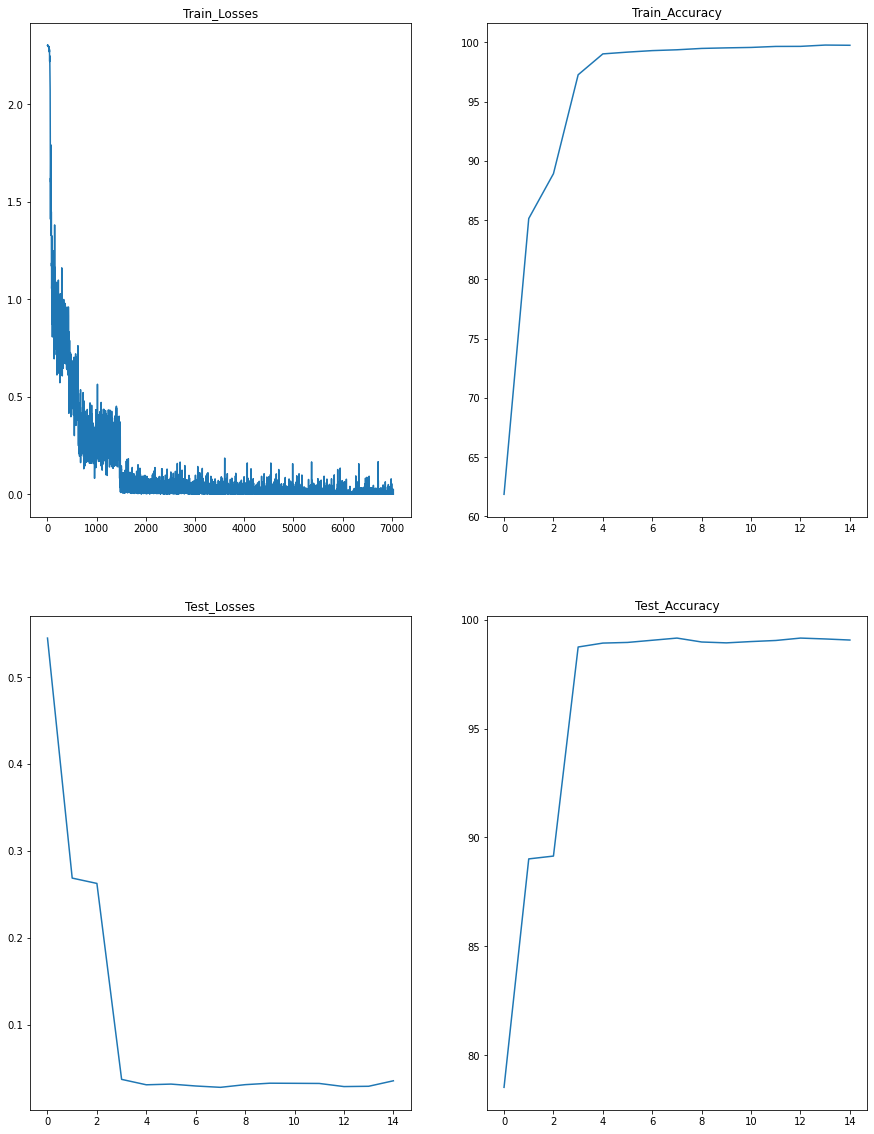

In [7]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(2,2,figsize=(15,20))
ax[0,0].plot(train_losses)
ax[0,0].set_title('Train_Losses')
ax[0,1].plot(train_accuracy)
ax[0,1].set_title('Train_Accuracy')

ax[1,0].plot(test_losses)
ax[1,0].set_title('Test_Losses')
ax[1,1].plot(test_accuracy)
ax[1,1].set_title('Test_Accuracy')